Now we try to use the Spanish model to generate French female names. Therefore, we feed the French dataset in this model, conduct the same process, and see the result.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/female_names.csv

In [ ]:
file_path = '/content/drive/MyDrive/ASS 2/French.csv'

words = open(file_path, 'r').read().lower(). splitlines()
words[:8]

['marie',
 'nathalie',
 'sylvie',
 'isabelle',
 'stéphanie',
 'martine',
 'valérie',
 'sandrine']

In [ ]:
len(words)

501

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'ç', 29: 'è', 30: 'é', 31: 'ë', 32: 'ï', 0: '.'}


In [ ]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
          ix = stoi.get(ch, stoi['.'])  # Map out-of-vocabulary characters to '.'
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
          #original: ix = stoi[ch]
          #else:
                #ix = stoi['.']
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([3453, 3]) torch.Size([3453])
torch.Size([415, 3]) torch.Size([415])
torch.Size([417, 3]) torch.Size([417])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((40, 10), generator=g)
W1 = torch.randn((30,400), generator=g)
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400, 31), generator=g)
b2 = torch.randn(31, generator=g)
parameters = [C, W1, b1, W2, b2]


In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

25231

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(300000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # Adjust input batch size here

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 31)  # Ensure logits shape matches the number of classes

    # Adjust target batch size here
    target_batch_size = 32  # Adjust target batch size here
    loss = F.cross_entropy(logits, Ytr[ix][:target_batch_size])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())


IndexError: Target 31 is out of bounds.

The error message "IndexError: Target 31 is out of bounds" indicates that the target index 31 is out of the bounds of the expected range. In your case, you have a total of 31 classes (characters), indexed from 0 to 30 (inclusive), but you're encountering an index of 31.

This error is occurring because your target tensor Ytr[ix] is likely containing indices greater than 30, which is beyond the number of classes your model is predicting. This could be due to unexpected characters in your dataset that are not accounted for in your vocabulary setup.

To resolve this issue, you need to ensure that your target tensor contains indices within the range of your vocabulary. One possible solution is to filter out any characters in your dataset that are not present in your vocabulary during the dataset building phase. You can do this by modifying the build_dataset function to filter out such characters.

It seems that even after adjusting the dataset building process to handle out-of-vocabulary characters, the issue persists.

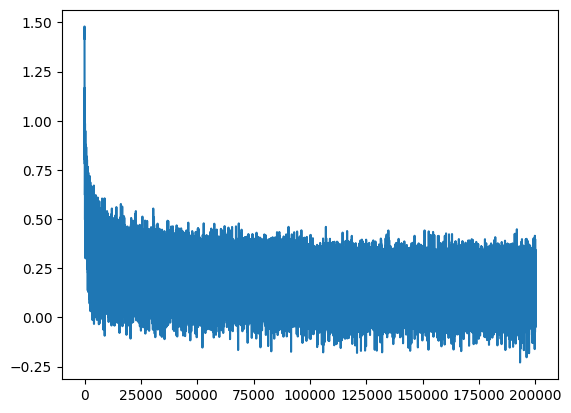

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4595, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.5152, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5252, grad_fn=<NllLossBackward0>)

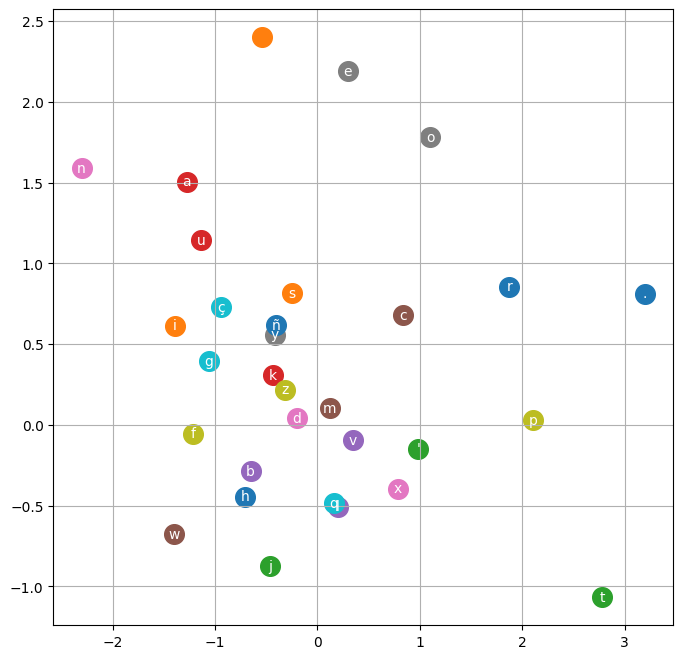

In [ ]:
# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
for i in range(C.shape[0]):
    if i in itos:  # Check if the index exists in itos
        plt.scatter(C[i, 0].item(), C[i, 1].item(), s=200)
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

cristika montserra.
maria.
crisa.
cheriye.
mona beatriciana carmen.
valena pilar.
amaria alenta.
tana eugenia.
andra mona.
rosa asceneavona coscocio.
jesus.
maria carmen ewo.
sofia ioanasrad.
asrina.
cimaela yuladosimonia.
enca andrea vanessamona angela tereusenciscrret.
maria maria janes.
veronica grena ine alenavita.
sonia.
rosariela masba.


In [ ]:
correct = 0
total = 0

# Evaluate on the validation set
for i in range(Xdev.shape[0]):
    emb = C[Xdev[i]]  # (block_size, embedding_dim)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (1, hidden_dim)
    logits = h @ W2 + b2  # (1, num_classes)
    prediction = torch.argmax(logits, dim=1).item()
    if prediction == Ydev[i].item():
        correct += 1
    total += 1

accuracy = correct / total
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5283783323686629
